In [20]:
# Autor: Daniel Pinto
# Heaps y Colas de Prioridad
# Fecha: 2021/10/01 YYYY/MM/DD
from typing import List, TypeVar, Tuple, Any, Callable, Optional, Generic, Dict
from hypothesis import given, strategies as st
from IPython.display import Markdown, display
from itertools import accumulate
from functools import reduce
from dataclasses import dataclass, field
from __future__ import annotations 
from copy import deepcopy
from collections.abc import  Iterable
import graphviz




def display_(s : str) -> None:
    '''
    A way to display strings with markdown 
    in jupyter.
    '''
    display(
        Markdown(s)
    )


SUCCESS_COLOR = '#4BB543'
ERROR_COLOR   = '#B00020'

def color_text(s : str, color : str =SUCCESS_COLOR ) -> str:
    return f"<span style='color:{color}'> {s} </span>."


a      = TypeVar('a')
b      = TypeVar('b')
c      = TypeVar('c')
T      = TypeVar('T')

[-8, -5, -3, -9, 4, -4, -1, -4, -7, 6]
{-8: [1], -5: [8], -3: [5], -9: [0], 4: [4], -4: [2, 7], -1: [6], -7: [3], 6: [9]}
[(-9, -9), (-8, -8), (-4, -4), (-7, -7), (4, 4), (-3, -3), (-1, -1), (-4, -4), (-5, -5), (6, 6)]


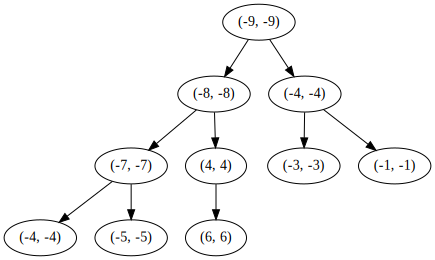

In [21]:
@dataclass
class Heap(Generic[T,a]):
    arr         : List[Tuple[a,T]]  
    assocs      : Dict[T,List[int]] 
    is_max_heap : bool          
    lt          : Callable[[a,a],bool]   
    gt          : Callable[[a,a],bool]   

    def __init__(self, is_max_heap : bool) -> None:
        self.arr         = []
        self.assocs      = {}
        self.is_max_heap = is_max_heap
        self.lt          = (lambda x,y: x<y ) if is_max_heap else (lambda x,y: x>y )
        self.gt          = (lambda x,y: x>y ) if is_max_heap else (lambda x,y: x<y )


    def up_heapify(self, i : int):
        p : int = (i-1) // 2
        while(True):
            if (p<0) or self.gt(self.arr[p][0], self.arr[i][0]):
                return
            
            # p : 3
            # p_val : [0,3,5]
            p_val   : T   = self.arr[p][1]
            i_val   : T   = self.arr[i][1]
            p_index : int = self.assocs[p_val].index(p)
            i_index : int = self.assocs[i_val].index(i)

            self.assocs[p_val][p_index] = i
            self.assocs[i_val][i_index] = p
            
            self.arr[p], self.arr[i] = self.arr[i], self.arr[p]

            i = p
            p = (p-1) // 2

    def down_heapify(self,i : int):
        l : int = (2*i) + 1
        r : int = (2*i) + 2
        largest : int = -1
        n : int = len(self.arr) - 1
        
        if l>n and r>n:
            return
        if r>n:
            r=l
        if l>n:
            l=r

        if self.gt(self.arr[i][0], self.arr[l][0] ) and self.gt(self.arr[i][0], self.arr[r][0]):
            return


        if self.gt(self.arr[l][0], self.arr[r][0]):
            largest = l
        else:
            largest = r
        

        largest_val   : T   = self.arr[largest][1]
        i_val         : T   = self.arr[i][1]
        largest_index : int = self.assocs[largest_val].index(largest)
        i_index : int = self.assocs[i_val].index(i)

        self.assocs[largest_val][largest_index] = i
        self.assocs[i_val][i_index] = largest

        self.arr[largest], self.arr[i] = self.arr[i], self.arr[largest]

        self.down_heapify(largest)

    def extract_root_(self) -> Optional[T]:
        if self.arr == []:
            return None
        
        root : T = self.arr[0][1]
        self.arr[0], self.arr[-1] = self.arr[-1], self.arr[0]

        new_root : T = self.arr[0][1]
        n : int = len(self.arr) - 1
        n_index : int = self.assocs[new_root].index(n) 
        self.assocs[new_root][n_index] = 0 


        self.arr.pop()

        self.down_heapify(0)
        
        return root
        


    def insert_(self, x:T, priority : a):
        self.arr.append((priority,x))
        n : int = len(self.arr) - 1
        if x in self.assocs:
            self.assocs[x].append(n)
        else:
            self.assocs[x] = [n]

        self.up_heapify(n)



    def push_pop(self,x : T, priority : a) -> T:
        if self.arr == []:
            return x
        if self.gt(priority,  self.arr[0][0]):
            return x
        root : T = self.arr[0][1]
        if self.assocs[root] == []:
            self.assocs.pop(root)
        else:
            self.assocs[root].remove(0)
        if x in self.assocs:
            self.assocs[x].append(0)
        else:
            self.assocs[x] = [0]
        self.arr[0] = (priority,x)
        self.down_heapify(0) 

        return root

    def modify_val(self, x:T, priority : a, f : Callable[[T,a,a],a] = lambda val,new,old: new):
        if x not in self.assocs:
            return
        pos_x = self.assocs[x][0]

        (p,v) = self.arr[pos_x]
        p_    = f(x,priority,p)

        self.arr[pos_x] = (p_,v)
        
        self.down_heapify(pos_x)
        self.up_heapify(pos_x)

    def toPic(self) -> Digraph:
        dot : Digraph = graphviz.Digraph(comment='Heap')
        current : int = 0
        if self.arr == []:
            return dot
        dot.node(str(0),str(self.arr[0]))
        for i in range(1,len(self.arr)):
            dot.node(str(i),str(self.arr[i]))
            dot.edge(str((i-1)//2),str(i))
        return dot 

def randomHeap(size : int = 10 ) -> Heap[int,int]:
    from random import randint
    acc  : List[int] = []
    heap : Heap[int,int] = Heap(is_max_heap=False) 
    for _ in range(size):
        n = randint(-size,size)
        acc.append(n)
        heap.insert_(n,n)
    
    print(acc)
    return heap




h : Heap[int,int] = randomHeap()        
#h.toPic().view(filename="name.gv",cleanup=True,)
#print(h.extract_root())
print(h.assocs)
print(h.arr)
h.toPic()





# Exercise: Sort an array

Given an array `arr` return a sorted array in time `n log n`


In [22]:
# n*log(n)
def heap_sort(arr : List[a]) -> List[a]:
    # orden o prioridad
    heap : Heap[(a,a)] = Heap(is_max_heap=False)
    res  : List[a]     = []
    for elem in arr:
        heap.insert_(elem,elem)
    
    while (max_h := heap.extract_root_()) is not None:
        res.append(max_h)


    return res

a = [5,7,0,2,6,-1,10]
print(heap_sort(a))

[-1, 0, 2, 5, 6, 7, 10]


# Exercise: Merge Sorted Arrays

Given a list of sorted arrays: `arr` merge them  in a sorted manner:

## Example

```
in:
    arr = [[1,5,9,15],[-1,3],[0,20,21],[2,4,6,8]]
out:
    [-1,0,1,3,4,5,6,9,15,20,21]
```



In [23]:
# n*log(n)

# n*log(4) = n*log(m)

# 4
# 10000000

# "llenar" el heap / llenar el pipe
# heap de altura max 4:
# [[5,9,15],[],[21],[4,6,8]]
# 2 4 3 20



def merge_sorted(arr : List[List[a]]) -> List[a]:
    n : int = len(arr)
    heap : Heap[a,a] = Heap(is_max_heap=False)
    i : int = 0
    res : List[a]   = []
    for sub_arr in arr:
        heap.insert_(sub_arr[0],sub_arr[0])
        print(heap.arr)
        sub_arr.pop(0)
    

    while(True):
        if arr == []:
            while (root := heap.extract_root_()) is not None:
                res.append(root)
            return res
        
        if arr[i] == []:
            arr.pop(i)
            n = n - 1
            continue
        
        heap.insert_(arr[i][0],arr[i][0])
        val = heap.extract_root_()
        arr[i].pop(0)
        res.append(val)
        print(heap.arr)
        i = (i + 1) % n


# res = -1 0 1 2

xs = [[1,5,9,15],[-1,3],[0,20,21],[2,4,6,8]]
print(merge_sorted(xs))



[(1, 1)]
[(-1, -1), (1, 1)]
[(-1, -1), (1, 1), (0, 0)]
[(-1, -1), (1, 1), (0, 0), (2, 2)]
[(0, 0), (1, 1), (5, 5), (2, 2)]
[(1, 1), (2, 2), (5, 5), (3, 3)]
[(2, 2), (3, 3), (5, 5), (20, 20)]
[(3, 3), (4, 4), (5, 5), (20, 20)]
[(4, 4), (9, 9), (5, 5), (20, 20)]
[(5, 5), (9, 9), (21, 21), (20, 20)]
[(6, 6), (9, 9), (21, 21), (20, 20)]
[(9, 9), (15, 15), (21, 21), (20, 20)]
[(9, 9), (15, 15), (21, 21), (20, 20)]
[-1, 0, 1, 2, 3, 4, 5, 6, 8, 9, 15, 20, 21]


# Exercise: Sort a nearly sorted (K-Sorted) array


Given an array of n elements, where each element is at most `k` elements away from its target position, devise an algorithm that runs in time `n log k` that sorts it.

For example, let us consider `k=2`, an element at index 7 in the sorted array can be at indexes 5,6,7,8,9 in the given array


## Example:

```
in: 
    arr: [6,5,3,2,8,10,9]
    k  :  3

out:
    [2,3,5,6,8,9,10]
```



In [24]:


#sol: fill the k-th queue and then popinsert.

# Exercise: Find Median from Data Stream

The median is the middle value in an ordered integer list. If the size of the list is even, there is no middle value and the median is the mean of the two middle values.

For example, for `arr = [2,3,4]`, the median is 3.
For example, for `arr = [2,3]`, the median is (2 + 3) / 2 = 2.5.

Given a Stream of numbers, find the median at each point:

```
in:
    1 : s -> median 1
    2 : s -> median (1+2) // 2
    3 : s -> median 2
    0 : s -> median (1+2) // 3

```




In [43]:
class Stream():
    
    def __init__(self) -> None:
        self.arr = [1,2,3,0,2,5,-1,1]
    
    def next(self) -> float:
        val = self.arr[0]
        self.arr.pop(0)
        return val


'''
1 -> [1]   []
2 -> [1]   [2]
3 -> [3,1] [2]

2.1 -> [2.1,1]  [2,3]
5   -> [5,2.1,1] [2,3] 
'''

# BST


# [ la mayor de las cotas inferiores | la menor de las coras superiores]

# una forma de particionar el arreglo miti y miti
# una forma de particionar el arreglo n/m n+m=longitud

def findMedian(s : Stream):
    min_heap : Heap[float,float] = Heap(is_max_heap=False)
    max_heap : Heap[float,float] = Heap(is_max_heap=True)

    while(True):
        val = s.next()
        # For the purpose of this exercise
        # we check if we consumed the stream
        if s.arr == []:
            return
        
        if len(max_heap.arr) == len(min_heap.arr) + 1:
            max_heap.insert_(val,val)
            aux : float = max_heap.extract_root_()
            min_heap.insert_(aux,aux)
            print((min_heap.arr[0][1] + max_heap.arr[0][1])//2)
        else:
            max_heap.insert_(val,val)
            try:
                print(min_heap.arr[0][1])
            except:
                print(max_heap.arr[0][1])
s = Stream()
findMedian(s)

# 0 1 2 2 3
# 1 1 2 1 2


1
1
2
1
2
2
2


# Exercise: Pond

Imagina que tienes n lagos que pueden estar: o vacios o llenos. Adicionalmente tienes un arreglo `arr` cuya posicion `i` indica que va a llover en el lago `arr[i]`, si  `arr[i] =-1` entonces podemos tomar ese dia para vaciar exactmente un lago.


Indique si es posible que ningun lago se desborde (un lago se desborda si su valor llega a ser mayor que 1)

## Example 

```
input:
    [0,1,2]
output:
    Ningun lago se desborda porque: en el dia 0 se llena el lago 0
                                    en el dia 1 se llena el lago 1
                                    en el dia 1 se llena el lago 2


input:
    [0,1,2,1]
output:
    El lago 1 se desborda pues en el dia 1 se llena, y luego se vuelve a llenar en el dia 3, estando ya lleno




input:
    [0,1,2,-1,2]


output:
    Ningun lago se desboarda pues: en el dia 0 se llena el lago 0
                                   en el dia 1 se llena el lago 1
                                   en el dia 1 se llena el lago 2
                                   en el dia 3 se limpia el lago 2
                                   en el dia 4 se llena el lago 2


```



In [ ]:
# 